CUSTOMER SEGMENTATION ANALYSIS (RFM)
Dataset: 400,891 transactions from 4,308 customers
Analysis Period: 2009-12-01 to 2010-12-09

CALCULATING RFM METRICS
----------------------------------------
RFM metrics calculated for 4,308 customers

CREATING RFM SCORES
----------------------------------------
RFM scores created (Range: 3-15)

CUSTOMER SEGMENTATION
----------------------------------------
Customer Segment Distribution:
                     Customer_Count  Avg_Recency  Avg_Frequency  Avg_Monetary  \
Customer_Segment                                                                
Champions                       926        12.67          11.67       6150.99   
Hibernating                     780       225.63           1.04        215.19   
Others                          508       125.09           1.45        552.66   
Potential_Loyalists             450        17.54           2.28        826.97   
Loyal_Customers                 432        40.22           5.54       1912.12   
Need

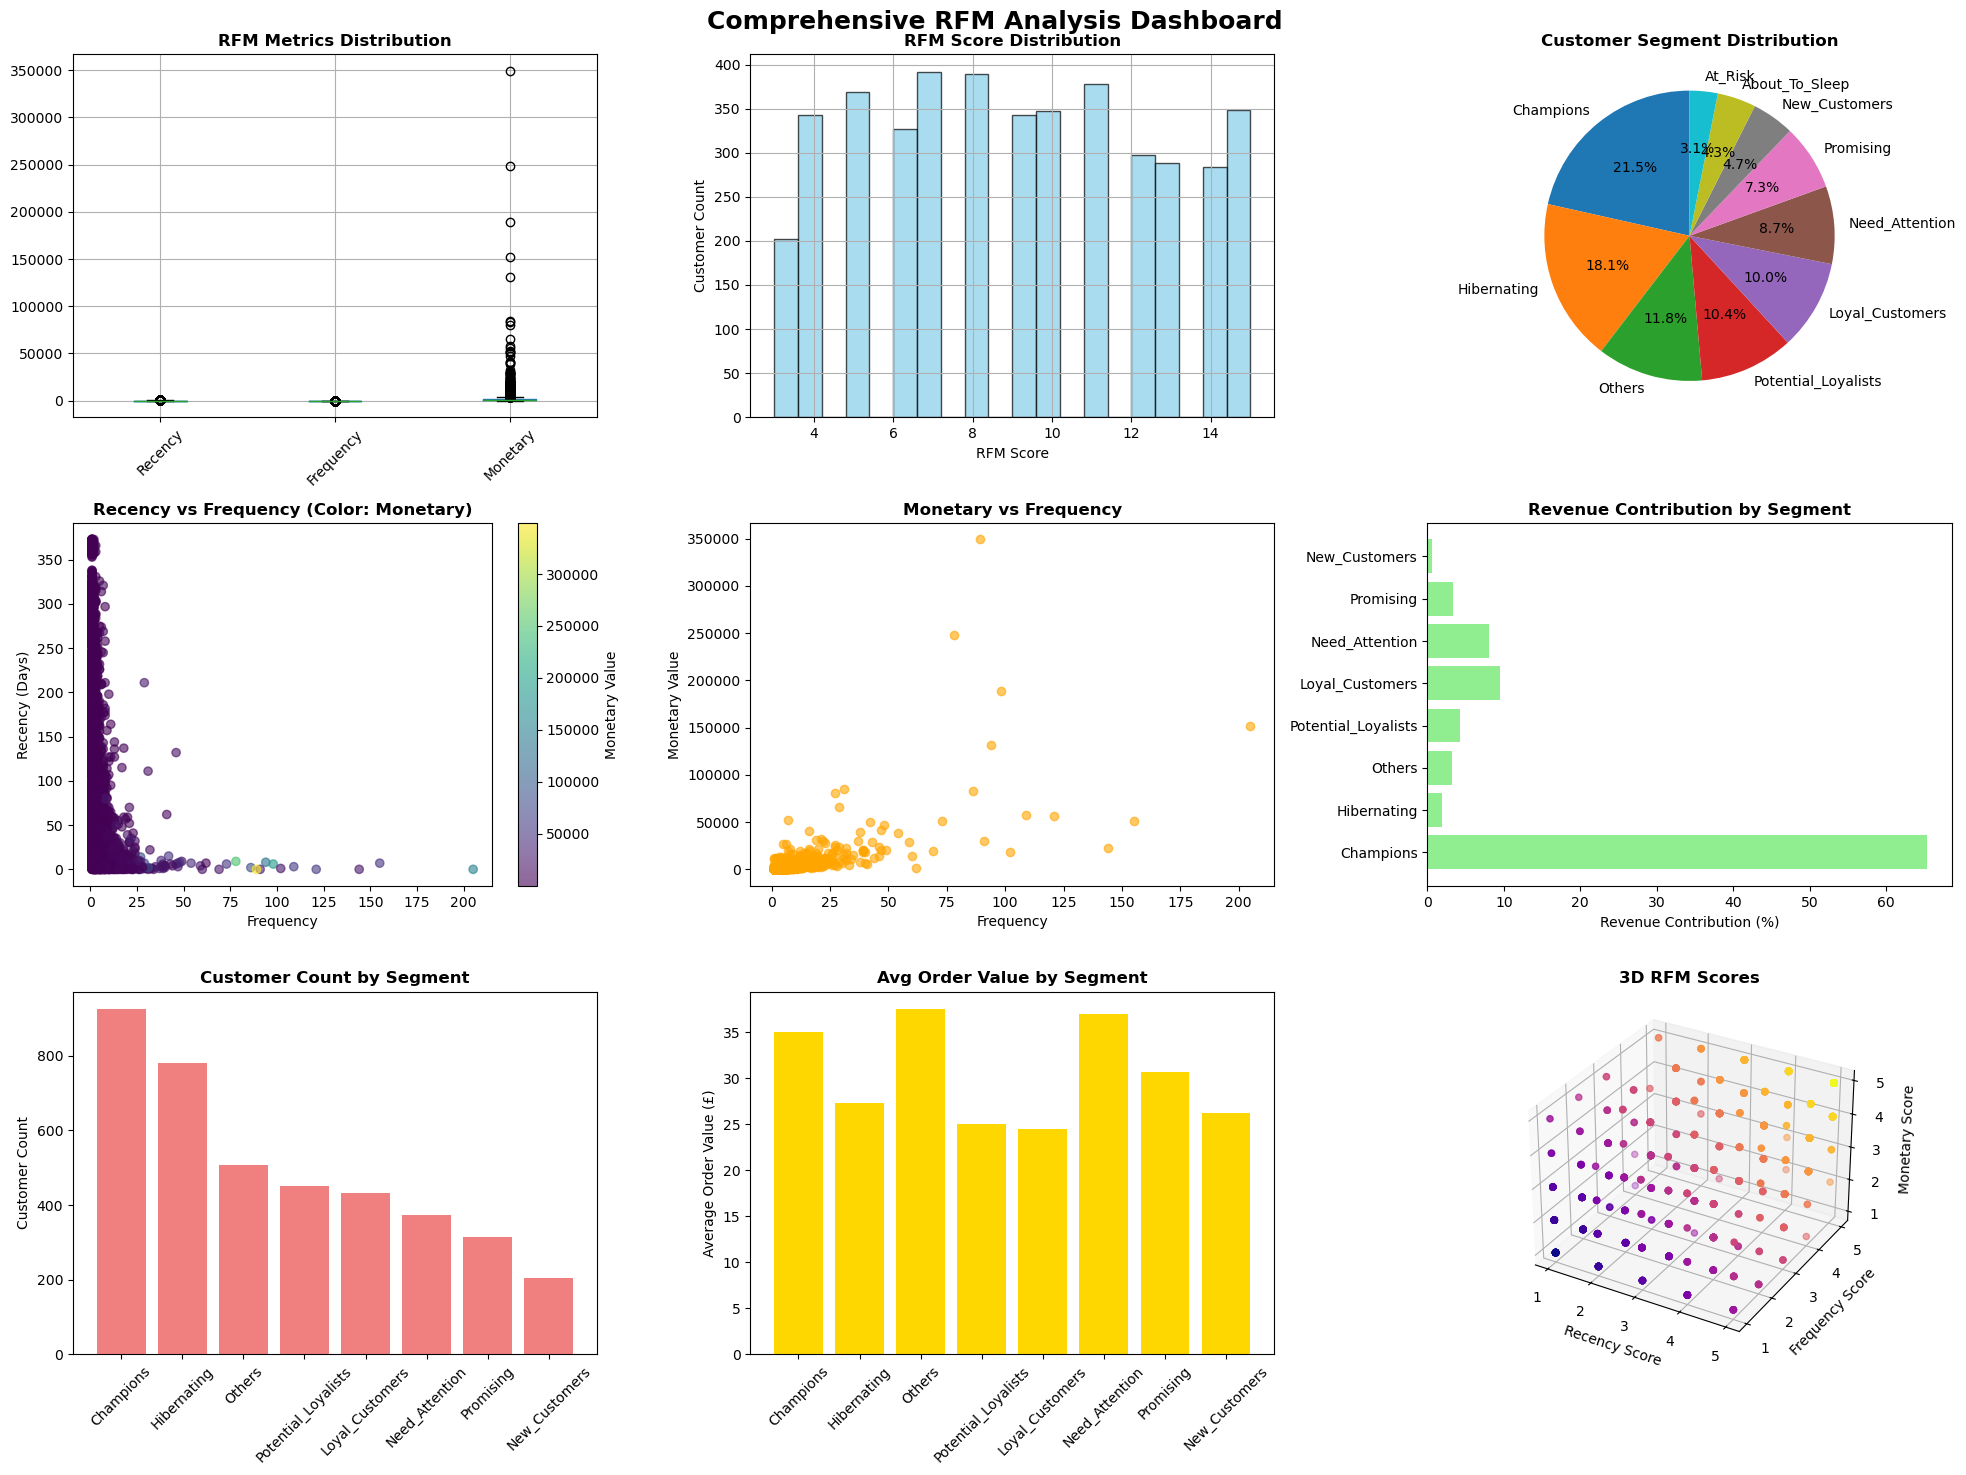

RFM visualizations created and saved

BUSINESS RECOMMENDATIONS
Champions (926 customers):
   • Avg Revenue: £6150.99
   • Strategy: Reward loyalty, ask for reviews, upsell premium products
At Risk (135 customers):
   • Avg Revenue: £1831.50
   • Strategy: Send personalized offers, limited-time promotions
Hibernating (780 customers):
   • Avg Revenue: £215.19
   • Strategy: Re-engagement campaigns, win-back offers

Results saved to '../data/processed/customer_segments.csv'
RFM ANALYSIS COMPLETE!


In [2]:
"""
Customer Segmentation Analysis using RFM
========================================
Author: Komal
Date: August 2025
Objective: Segment customers based on RFM analysis for targeted strategies
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("CUSTOMER SEGMENTATION ANALYSIS (RFM)")
print("="*60)

# Load cleaned data
df = pd.read_csv('../data/processed/cleaned_data.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(f"Dataset: {df.shape[0]:,} transactions from {df['CustomerID'].nunique():,} customers")
print(f"Analysis Period: {df['InvoiceDate'].min().date()} to {df['InvoiceDate'].max().date()}")

class RFMAnalyzer:
    """
    Professional RFM (Recency, Frequency, Monetary) Analysis Implementation
    """
    
    def __init__(self, data, customer_col='CustomerID', date_col='InvoiceDate', 
                 amount_col='TotalAmount', invoice_col='InvoiceNo'):
        self.data = data
        self.customer_col = customer_col
        self.date_col = date_col
        self.amount_col = amount_col
        self.invoice_col = invoice_col
        self.analysis_date = data[date_col].max()
        
    def calculate_rfm_metrics(self):
        """Calculate RFM metrics for each customer"""
        print("\nCALCULATING RFM METRICS")
        print("-" * 40)
        
        # Calculate RFM metrics
        rfm_data = self.data.groupby(self.customer_col).agg({
            self.date_col: lambda x: (self.analysis_date - x.max()).days,  # Recency
            self.invoice_col: 'nunique',  # Frequency
            self.amount_col: 'sum'        # Monetary
        }).reset_index()
        
        rfm_data.columns = [self.customer_col, 'Recency', 'Frequency', 'Monetary']
        
        # Additional customer metrics
        customer_metrics = self.data.groupby(self.customer_col).agg({
            self.amount_col: ['mean', 'std', 'count'],
            'Quantity': 'sum'
        }).round(2)
        
        customer_metrics.columns = ['AvgOrderValue', 'StdOrderValue', 'TotalOrders', 'TotalItems']
        
        # Merge metrics
        self.rfm_df = rfm_data.merge(customer_metrics.reset_index(), on=self.customer_col)
        
        print(f"RFM metrics calculated for {len(self.rfm_df):,} customers")
        return self.rfm_df
    
    def create_rfm_scores(self, r_bins=5, f_bins=5, m_bins=5):
        """Create RFM scores using quintile-based scoring"""
        print("\nCREATING RFM SCORES")
        print("-" * 40)
        
        # Create RFM scores (1-5 scale)
        self.rfm_df['R_Score'] = pd.qcut(self.rfm_df['Recency'], r_bins, labels=[5,4,3,2,1])
        self.rfm_df['F_Score'] = pd.qcut(self.rfm_df['Frequency'].rank(method='first'), f_bins, labels=[1,2,3,4,5])
        self.rfm_df['M_Score'] = pd.qcut(self.rfm_df['Monetary'], m_bins, labels=[1,2,3,4,5])
        
        # Convert to numeric
        self.rfm_df['R_Score'] = self.rfm_df['R_Score'].astype(int)
        self.rfm_df['F_Score'] = self.rfm_df['F_Score'].astype(int)
        self.rfm_df['M_Score'] = self.rfm_df['M_Score'].astype(int)
        
        # Combined RFM Score
        self.rfm_df['RFM_Score'] = (self.rfm_df['R_Score'].astype(str) + 
                                   self.rfm_df['F_Score'].astype(str) + 
                                   self.rfm_df['M_Score'].astype(str))
        
        # Numeric RFM Score for easier analysis
        self.rfm_df['RFM_Numeric'] = (self.rfm_df['R_Score'] + 
                                     self.rfm_df['F_Score'] + 
                                     self.rfm_df['M_Score'])
        
        print(f"RFM scores created (Range: {self.rfm_df['RFM_Numeric'].min()}-{self.rfm_df['RFM_Numeric'].max()})")
        return self.rfm_df
    
    def segment_customers(self):
        """Segment customers based on RFM scores"""
        print("\nCUSTOMER SEGMENTATION")
        print("-" * 40)
        
        def categorize_customer(row):
            """Categorize customers based on RFM scores"""
            r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
            
            # Champions: High value, frequent, recent customers
            if r >= 4 and f >= 4 and m >= 4:
                return 'Champions'
            
            # Loyal Customers: High frequency and monetary, recent
            elif r >= 3 and f >= 4 and m >= 3:
                return 'Loyal_Customers'
            
            # Potential Loyalists: Recent customers with good frequency or monetary
            elif r >= 4 and f >= 2 and m >= 2:
                return 'Potential_Loyalists'
            
            # New Customers: Very recent but low frequency
            elif r >= 4 and f <= 2 and m <= 3:
                return 'New_Customers'
            
            # Promising: Recent customers with potential
            elif r >= 3 and f >= 2 and m >= 2:
                return 'Promising'
            
            # Need Attention: Declining recency but good historical value
            elif r >= 2 and f >= 3 and m >= 3:
                return 'Need_Attention'
            
            # About to Sleep: Declining engagement
            elif r >= 2 and f >= 2 and m >= 2:
                return 'About_To_Sleep'
            
            # At Risk: Were valuable but declining
            elif r <= 2 and f >= 3 and m >= 3:
                return 'At_Risk'
            
            # Cannot Lose: High value but haven't purchased recently
            elif r <= 2 and f >= 4 and m >= 4:
                return 'Cannot_Lose'
            
            # Hibernating: Low engagement across all metrics
            elif r <= 2 and f <= 2 and m <= 2:
                return 'Hibernating'
            
            else:
                return 'Others'
        
        self.rfm_df['Customer_Segment'] = self.rfm_df.apply(categorize_customer, axis=1)
        
        # Segment summary
        segment_summary = self.rfm_df.groupby('Customer_Segment').agg({
            self.customer_col: 'count',
            'Recency': 'mean',
            'Frequency': 'mean',
            'Monetary': 'mean',
            'AvgOrderValue': 'mean'
        }).round(2)
        
        segment_summary.columns = ['Customer_Count', 'Avg_Recency', 'Avg_Frequency', 
                                 'Avg_Monetary', 'Avg_Order_Value']
        
        # Calculate percentage
        segment_summary['Percentage'] = (segment_summary['Customer_Count'] / 
                                       len(self.rfm_df) * 100).round(1)
        
        # Calculate revenue contribution
        segment_revenue = self.rfm_df.groupby('Customer_Segment')['Monetary'].sum()
        segment_summary['Revenue_Contribution'] = (segment_revenue / 
                                                 segment_revenue.sum() * 100).round(1)
        
        self.segment_summary = segment_summary.sort_values('Customer_Count', ascending=False)
        
        print("Customer Segment Distribution:")
        print(self.segment_summary)
        
        return self.segment_summary
    
    def visualize_rfm_analysis(self):
        """Create comprehensive visualizations for RFM analysis"""
        print("\nCREATING RFM VISUALIZATIONS")
        print("-" * 40)
        
        # Create subplot layout
        fig = plt.figure(figsize=(20, 15))
        
        # 1. RFM Distribution
        plt.subplot(3, 3, 1)
        self.rfm_df[['Recency', 'Frequency', 'Monetary']].boxplot(ax=plt.gca())
        plt.title('RFM Metrics Distribution', fontweight='bold')
        plt.xticks(rotation=45)
        
        # 2. RFM Score Distribution
        plt.subplot(3, 3, 2)
        self.rfm_df['RFM_Numeric'].hist(bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title('RFM Score Distribution', fontweight='bold')
        plt.xlabel('RFM Score')
        plt.ylabel('Customer Count')
        
        # 3. Customer Segment Distribution
        plt.subplot(3, 3, 3)
        segment_counts = self.rfm_df['Customer_Segment'].value_counts()
        plt.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%', startangle=90)
        plt.title('Customer Segment Distribution', fontweight='bold')
        
        # 4. Recency vs Frequency
        plt.subplot(3, 3, 4)
        scatter = plt.scatter(self.rfm_df['Frequency'], self.rfm_df['Recency'], 
                            c=self.rfm_df['Monetary'], cmap='viridis', alpha=0.6)
        plt.colorbar(scatter, label='Monetary Value')
        plt.xlabel('Frequency')
        plt.ylabel('Recency (Days)')
        plt.title('Recency vs Frequency (Color: Monetary)', fontweight='bold')
        
        # 5. Monetary vs Frequency
        plt.subplot(3, 3, 5)
        plt.scatter(self.rfm_df['Frequency'], self.rfm_df['Monetary'], alpha=0.6, color='orange')
        plt.xlabel('Frequency')
        plt.ylabel('Monetary Value')
        plt.title('Monetary vs Frequency', fontweight='bold')
        
        # 6. Top segments by revenue
        plt.subplot(3, 3, 6)
        top_segments = self.segment_summary.head(8)
        plt.barh(range(len(top_segments)), top_segments['Revenue_Contribution'], color='lightgreen')
        plt.yticks(range(len(top_segments)), top_segments.index)
        plt.xlabel('Revenue Contribution (%)')
        plt.title('Revenue Contribution by Segment', fontweight='bold')
        
        # 7. Customer count by segment
        plt.subplot(3, 3, 7)
        plt.bar(range(len(top_segments)), top_segments['Customer_Count'], color='lightcoral')
        plt.xticks(range(len(top_segments)), top_segments.index, rotation=45)
        plt.ylabel('Customer Count')
        plt.title('Customer Count by Segment', fontweight='bold')
        
        # 8. Average order value by segment
        plt.subplot(3, 3, 8)
        plt.bar(range(len(top_segments)), top_segments['Avg_Order_Value'], color='gold')
        plt.xticks(range(len(top_segments)), top_segments.index, rotation=45)
        plt.ylabel('Average Order Value (£)')
        plt.title('Avg Order Value by Segment', fontweight='bold')
        
        # 9. RFM 3D Scatter (sample)
        from mpl_toolkits.mplot3d import Axes3D
        ax = plt.subplot(3, 3, 9, projection='3d')
        sample_data = self.rfm_df.sample(1000)  # Sample for better visualization
        scatter = ax.scatter(sample_data['R_Score'], sample_data['F_Score'], 
                           sample_data['M_Score'], c=sample_data['RFM_Numeric'], cmap='plasma')
        ax.set_xlabel('Recency Score')
        ax.set_ylabel('Frequency Score')
        ax.set_zlabel('Monetary Score')
        ax.set_title('3D RFM Scores', fontweight='bold')
        
        plt.suptitle('Comprehensive RFM Analysis Dashboard', fontsize=18, fontweight='bold')
        plt.tight_layout()
        plt.savefig('../reports/rfm_analysis_dashboard.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("RFM visualizations created and saved")

# Execute RFM Analysis
rfm_analyzer = RFMAnalyzer(df)

# Calculate metrics
rfm_results = rfm_analyzer.calculate_rfm_metrics()
rfm_scored = rfm_analyzer.create_rfm_scores()
segment_analysis = rfm_analyzer.segment_customers()

# Create visualizations
rfm_analyzer.visualize_rfm_analysis()

# Generate business recommendations
print(f"\nBUSINESS RECOMMENDATIONS")
print("=" * 60)

champions = rfm_analyzer.rfm_df[rfm_analyzer.rfm_df['Customer_Segment'] == 'Champions']
at_risk = rfm_analyzer.rfm_df[rfm_analyzer.rfm_df['Customer_Segment'] == 'At_Risk']
hibernating = rfm_analyzer.rfm_df[rfm_analyzer.rfm_df['Customer_Segment'] == 'Hibernating']

print(f"Champions ({len(champions)} customers):")
print(f"   • Avg Revenue: £{champions['Monetary'].mean():.2f}")
print(f"   • Strategy: Reward loyalty, ask for reviews, upsell premium products")

print(f"At Risk ({len(at_risk)} customers):")
print(f"   • Avg Revenue: £{at_risk['Monetary'].mean():.2f}")  
print(f"   • Strategy: Send personalized offers, limited-time promotions")

print(f"Hibernating ({len(hibernating)} customers):")
print(f"   • Avg Revenue: £{hibernating['Monetary'].mean():.2f}")
print(f"   • Strategy: Re-engagement campaigns, win-back offers")

# Save results
rfm_analyzer.rfm_df.to_csv('../data/processed/customer_segments.csv', index=False)
rfm_analyzer.segment_summary.to_csv('../reports/segment_summary.csv')

print(f"\nResults saved to '../data/processed/customer_segments.csv'")
print(f"RFM ANALYSIS COMPLETE!")
print("=" * 60)
